In [ ]:
### Intro to AI Group 3 Final Project - Using CV to Predict Ocular Disease

In [42]:
## need to make folder for training, validation, and testing
## need to make folder for each category in each of the above folders
## need to copy images into the training folder
## grab 15% for test
## grab 15% for validation

train_base_dir = "C:\\Users\\elanw\\OneDrive\\Documents\\IntroToAI\\ocular_dataset\\train"
valid_base_dir = "C:\\Users\\elanw\\OneDrive\\Documents\\IntroToAI\\ocular_dataset\\valid"
test_base_dir = "C:\\Users\\elanw\\OneDrive\\Documents\\IntroToAI\\ocular_dataset\\test"
image_dir = "C:\\Users\\elanw\\OneDrive\\Documents\\IntroToAI\\ocular_dataset\\preprocessed_images\\"
categs = ['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O']

if not os.path.exists(train_base_dir):
        os.mkdir(train_base_dir)
if not os.path.exists(valid_base_dir):
        os.mkdir(valid_base_dir)
if not os.path.exists(test_base_dir):
        os.mkdir(test_base_dir)

for categ in categs:
    if not os.path.exists(train_base_dir + "\\" + categ):
        os.mkdir(train_base_dir + "\\" + categ)
for categ in categs:
    if not os.path.exists(valid_base_dir + "\\" + categ):
        os.mkdir(valid_base_dir + "\\" + categ)
for categ in categs:
    if not os.path.exists(test_base_dir + "\\" + categ):
        os.mkdir(test_base_dir + "\\" + categ)


for index, row in ocular_data.iterrows():
    l_file = str(row['ID']) + "_left.jpg"
    r_file = str(row['ID'])+ "_right.jpg"
    if row['N'] == 1:
        dest = train_base_dir + "\\N\\"
    elif row['D'] == 1:
        dest = train_base_dir + "\\D\\"
    elif row['G'] == 1:
        dest = train_base_dir + "\\G\\"
    elif row['C'] == 1:
        dest = train_base_dir + "\\C\\"
    elif row['A'] == 1:
        dest = train_base_dir + "\\A\\"
    elif row['H'] == 1:
        dest = train_base_dir + "\\H\\"
    elif row['M'] == 1:
        dest = train_base_dir + "\\M\\"
    elif row['O'] == 1:
        dest = train_base_dir + "\\O\\"
    if os.path.exists(image_dir + l_file):
        shutil.copy(image_dir + l_file, dest + l_file)
    if os.path.exists(image_dir + r_file):
        shutil.copy(image_dir + r_file, dest + r_file)

for categ in categs:
    numb_files = len(os.listdir(train_base_dir + "\\" + categ))
    fifteen_percent = numb_files * .15
    idx = -1
    for filename in os.listdir(train_base_dir + "\\" + categ):
        idx = idx + 1
        if idx < fifteen_percent:
            shutil.move(train_base_dir + "\\" + categ + "\\" + filename, valid_base_dir + "\\" + categ + "\\" + filename)
        elif idx < fifteen_percent * 2:
            shutil.move(train_base_dir + "\\" + categ + "\\" + filename, test_base_dir + "\\" + categ + "\\" + filename)
        else:
            break
     

# create directory for each category
# 

In [27]:
import keras
from tensorflow.keras.applications import VGG16
base_model = VGG16(weights='imagenet',
                   input_shape=(224, 224, 3),
                   include_top=False)
base_model.trainable = False

In [41]:
inputs = keras.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
outputs = keras.layers.Dense(8)(x)
xfer_vgg16_model = keras.Model(inputs, outputs)

In [43]:
#xfer_vgg16_model.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=[keras.metrics.SparseCategoricalAccuracy()])
xfer_vgg16_model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [29]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(samplewise_center=True, horizontal_flip=True, vertical_flip=False)
valid_datagen = ImageDataGenerator(samplewise_center=True, horizontal_flip=True, vertical_flip=False)
test_datagen = ImageDataGenerator(samplewise_center=True, horizontal_flip=True, vertical_flip=False)

In [37]:
train_it = train_datagen.flow_from_directory(train_base_dir, target_size=(224, 224), color_mode='rgb', class_mode='sparse', batch_size=8)
valid_it = valid_datagen.flow_from_directory(valid_base_dir, target_size=(224, 224), color_mode='rgb', class_mode='sparse', batch_size=8)
test_it = test_datagen.flow_from_directory(test_base_dir, target_size=(224, 224), color_mode='rgb', class_mode='sparse', batch_size=8)

Found 4469 images belonging to 8 classes.
Found 965 images belonging to 8 classes.
Found 958 images belonging to 8 classes.


In [44]:
xfer_vgg16_model.fit(train_it, epochs=5, validation_data=valid_it)

Epoch 1/10
559/559 [==============================] - 392s 701ms/step - loss: 6.5822 - accuracy: 0.3215 - val_loss: 6.1870 - val_accuracy: 0.2995
Epoch 2/10
559/559 [==============================] - 348s 622ms/step - loss: 6.1744 - accuracy: 0.3354 - val_loss: 6.2033 - val_accuracy: 0.2881
Epoch 3/10
559/559 [==============================] - 355s 636ms/step - loss: 4.8057 - accuracy: 0.2909 - val_loss: 2.0900 - val_accuracy: 0.1793
Epoch 4/10
559/559 [==============================] - 354s 633ms/step - loss: 2.0790 - accuracy: 0.2043 - val_loss: 2.0794 - val_accuracy: 0.1876
Epoch 5/10
559/559 [==============================] - 349s 624ms/step - loss: 2.0795 - accuracy: 0.1949 - val_loss: 2.0794 - val_accuracy: 0.1762
Epoch 6/10
559/559 [==============================] - 347s 621ms/step - loss: 2.0790 - accuracy: 0.1951 - val_loss: 2.1030 - val_accuracy: 0.1741
Epoch 7/10
559/559 [==============================] - 342s 611ms/step - loss: 2.0795 - accuracy: 0.1994 - val_loss: 2.0794 -

In [9]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

show_image('C:\\Users\\elanw\\OneDrive\\Pictures\\eye_square.jpg')
def show_image(image_path):
    image = mpimg.imread(image_path)
    plt.imshow(image)


NameError: name 'show_image' is not defined

In [30]:
from tensorflow.keras.preprocessing import image as image_utils
from tensorflow.keras.applications.vgg16 import preprocess_input

def load_and_process_image(image_path):
    img = image_utils.load_img(image_path, target_size=(224,224))
    img = image_utils.img_to_array(img)
    img = img.reshape(1,224,224,3)
    img = preprocess_input(img)
    return img

In [ ]:
from tensorflow.keras.applications.vgg16 import decode_predictions

def readable_predictions(image_path):
    show_image(image_path)
    image = load_and_process_image(image_path)
    predictions = model.predict(image)
    print('Predicted:', decode_predictions(predictions, top=3)[0])

1/1 [==============================] - 0s 146ms/step
Predicted: [('n01910747', 'jellyfish', 0.38048986), ('n03637318', 'lampshade', 0.31530604), ('n02782093', 'balloon', 0.0752076)]


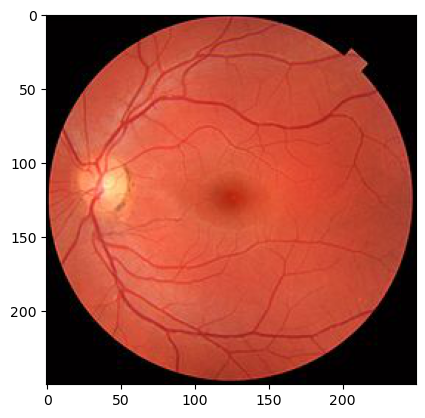

In [ ]:
readable_predictions('C:/Users/elanw/OneDrive/Pictures/fundus.jpg')